In [1]:
CANVAS_SIZE = 50                      # canvas in which 0/1/2 MNIST digits are put
MNIST_SIZE = 24                       # size of original MNIST digits (resized)
WINDOW_SIZE = MNIST_SIZE              # patch size (in one dimension) of what-VAE
Z_WHAT_HIDDEN_DIM = 400               # hidden dimension of what-VAE
Z_WHAT_DIM = 20                       # latent dimension of what-VAE
SIGMOID_BIAS = -3.                    # bias to encourage objects use
FIXED_VAR = 0.6**2                    # fixed variance of Gaussian decoder
Z_PRES_DIM = 1                        # latent dimension of z_pres
Z_WHERE_DIM = 3                       # latent dimension of z_where
RNN_HIDDEN_STATE_DIM = 256            # hidden state dimension of RNN
P_PRES_INIT = [2.]                    # initialization p_pres (sigmoid -> 0.8)
MU_WHERE_INIT = [3.0, 0., 0.]         # initialization z_where mean
LOG_VAR_WHERE_INIT = [-3.,-3.,-3.]    # initialization z_where log var
Z_DIM = Z_PRES_DIM + Z_WHERE_DIM + Z_WHAT_DIM 
N = 3                                 # number of inference steps
EPS = 1e-32                           # numerical stability
PRIOR_MEAN_WHERE = [3., 0., 0.]       # prior for mean of z_i_where
PRIOR_VAR_WHERE = [0.1**2, 1., 1.]    # prior for variance of z_i_where
PRIOR_P_PRES = [0.01]                 # prior for p_i_pres of z_i_pres
BETA = 0.7                            # hyperparameter to scale KL div
OMEGA_DIM = Z_PRES_DIM + 2*Z_WHERE_DIM + 2*Z_WHAT_DIM
EPOCHS = 50                           # number of training epochs
BATCH_SIZE = 64  
LEARNING_RATE = 1e-4                  # learning rate of model
BASE_LEARNING_RATE = 1e-2             # learning rate of neural baseline
EPOCHS_TO_SAVE_MODEL = [1, 10, EPOCHS]

In [2]:
import torch
import os
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from torch import nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from livelossplot import PlotLosses, outputs
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
if not os.path.exists('results'):
    os.makedirs('results')

In [3]:
def generate_dataset(num_images, SEED=1):
    """generates multiple MNIST dataset with 0, 1 or 2 non-overlaping digits

    Args:
        num_images (int): number of images inside dataset

    Returns:
        multiple_MNIST (torch dataset)
    """
    data = torch.zeros([num_images, 1, CANVAS_SIZE, CANVAS_SIZE])

    original_MNIST = datasets.MNIST('.', train=True, download=True,
        transform=transforms.Compose([
          transforms.Resize(size=(MNIST_SIZE, MNIST_SIZE)),
          transforms.ToTensor()]))
    # sample random digits and positions
    np.random.seed(SEED)
    pos_positions = np.arange(int(MNIST_SIZE/2),CANVAS_SIZE - int(MNIST_SIZE/2))

    mnist_indices = np.random.randint(len(original_MNIST), size=(num_images, 2))
    num_digits = np.random.randint(3, size=(num_images))
    positions_0 = np.random.choice(pos_positions, size=(num_images, 2),
                                   replace=True)

    for i_data in range(num_images):
        if num_digits[i_data] > 0:
            # add random digit at random position
            random_digit = original_MNIST[mnist_indices[i_data][0]][0]
            x_0, y_0 = positions_0[i_data][0], positions_0[i_data][1]
            x = [x_0-int(MNIST_SIZE/2), x_0+int(MNIST_SIZE/2)]
            y = [y_0-int(MNIST_SIZE/2), y_0+int(MNIST_SIZE/2)]
            data[i_data,:,y[0]:y[1],x[0]:x[1]] += random_digit
            if num_digits[i_data] == 2:
                # add second non overlaping random digit
                random_digit = original_MNIST[mnist_indices[i_data][1]][0]
                impos_x_pos = np.arange(x_0-int(MNIST_SIZE/2),
                                        x_0+int(MNIST_SIZE/2))
                impos_y_pos = np.arange(y_0-int(MNIST_SIZE/2),
                                        y_0+int(MNIST_SIZE/2))
                x_1 = np.random.choice(np.setdiff1d(pos_positions, impos_x_pos),
                                       size=1)[0]
                y_1 = np.random.choice(np.setdiff1d(pos_positions, impos_y_pos),
                                       size=1)[0]
                x = [x_1-int(MNIST_SIZE/2), x_1+int(MNIST_SIZE/2)]
                y = [y_1-int(MNIST_SIZE/2), y_1+int(MNIST_SIZE/2)]
                data[i_data,:,y[0]:y[1],x[0]:x[1]] += random_digit
    labels = torch.from_numpy(num_digits)
    return TensorDataset(data.type(torch.float32), labels)
  
train_dataset = generate_dataset(num_images=1000)

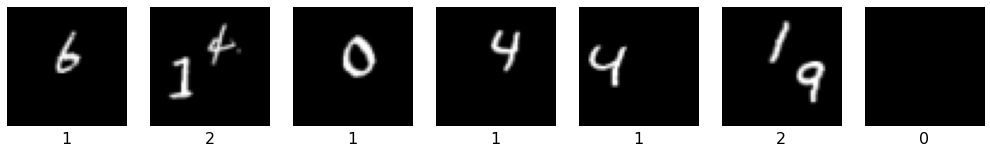

In [4]:
n_samples = 7
fig = plt.figure(figsize=(n_samples*2.5, 2.5))
i_samples = np.random.choice(range(len(train_dataset)), 
                             n_samples, replace=False)
for counter, i_sample in enumerate(i_samples):
    img, label = train_dataset[i_sample]
    
    plt.subplot(1, n_samples, counter + 1)
    plt.imshow(transforms.ToPILImage()(img), cmap='gray')
    plt.axis('off')
    plt.title(str(label.numpy()), fontsize=16, y=-0.2)

In [5]:
class VAE(nn.Module):
    """simple VAE class with a Gaussian encoder (mean and diagonal variance
    structure) and a Gaussian decoder with fixed variance

    Attributes:
        encoder (nn.Sequential): encoder network for mean and log_var
        decoder (nn.Sequential): decoder network for mean (fixed var)
    """

    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(WINDOW_SIZE**2, Z_WHAT_HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(Z_WHAT_HIDDEN_DIM, Z_WHAT_DIM*2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(Z_WHAT_DIM, Z_WHAT_HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(Z_WHAT_HIDDEN_DIM, WINDOW_SIZE**2),
        )
        self.bias = SIGMOID_BIAS
        return

    def forward(self, x_att_i):
        z_what_i, mu_E_i, log_var_E_i = self.encode(x_att_i)
        x_tilde_att_i = self.decode(z_what_i)
        return x_tilde_att_i, z_what_i, mu_E_i, log_var_E_i

    def encode(self, x_att_i):
        batch_size = x_att_i.shape[0]
        # get encoder distribution parameters
        out_encoder = self.encoder(x_att_i.view(batch_size, -1))
        mu_E_i, log_var_E_i = torch.chunk(out_encoder, 2, dim=1)
        # sample noise variable for each batch
        epsilon = torch.randn_like(log_var_E_i)
        # get latent variable by reparametrization trick
        z_what_i = mu_E_i + torch.exp(0.5*log_var_E_i) * epsilon
        return z_what_i, mu_E_i, log_var_E_i

    def decode(self, z_what_i):
        # get decoder distribution parameters
        x_tilde_att_i = self.decoder(z_what_i)
        x_tilde_att_i = torch.sigmoid(x_tilde_att_i + self.bias)
        # reshape to [1, WINDOW_SIZE, WINDOW_SIZE] (input shape)
        x_tilde_att_i = x_tilde_att_i.view(-1, 1, WINDOW_SIZE, WINDOW_SIZE)
        return x_tilde_att_i

In [6]:
class RNN(nn.Module):
    
    def __init__(self, baseline_net=False):
        super(RNN, self).__init__()
        self.baseline_net = baseline_net
        INPUT_SIZE = CANVAS_SIZE**2 + RNN_HIDDEN_STATE_DIM + Z_DIM
        if baseline_net:
            OUTPUT_SIZE = (RNN_HIDDEN_STATE_DIM + 1)
        else:
            OUTPUT_SIZE = (RNN_HIDDEN_STATE_DIM + Z_PRES_DIM + 2*Z_WHERE_DIM)
        output_layer = nn.Linear(RNN_HIDDEN_STATE_DIM, OUTPUT_SIZE)
        
        self.fc_rnn = nn.Sequential(
            nn.Linear(INPUT_SIZE, RNN_HIDDEN_STATE_DIM),
            nn.ReLU(),
            nn.Linear(RNN_HIDDEN_STATE_DIM, RNN_HIDDEN_STATE_DIM),
            nn.ReLU(),
            output_layer
        )
        if not baseline_net:            
            # initialize distribution parameters
            output_layer.weight.data[0:7] = nn.Parameter(
                torch.zeros(Z_PRES_DIM+2*Z_WHERE_DIM, RNN_HIDDEN_STATE_DIM)
            )
            output_layer.bias.data[0:7] = nn.Parameter(
                torch.tensor(P_PRES_INIT + MU_WHERE_INIT + LOG_VAR_WHERE_INIT)
            )
        return
    
    def forward(self, x, z_im1, h_im1):
        batch_size = x.shape[0]
        rnn_input = torch.cat((x.view(batch_size, -1), z_im1, h_im1), dim=1)
        rnn_output = self.fc_rnn(rnn_input)
        if self.baseline_net:
            baseline_value_i = rnn_output[:, 0:1]
            h_i = rnn_output[:, 1::]
            return baseline_value_i, h_i
        else:
            omega_i = rnn_output[:, 0:(Z_PRES_DIM+2*Z_WHERE_DIM)]
            h_i = rnn_output[:, (Z_PRES_DIM+2*Z_WHERE_DIM)::]
            # omega_i[:, 0] corresponds to z_pres probability
            omega_i[:, 0] = torch.sigmoid(omega_i[:, 0])
            return omega_i, h_i

In [7]:
class AIR(nn.Module):
    
    PRIOR_MEAN_Z_WHERE = nn.Parameter(torch.tensor(PRIOR_MEAN_WHERE), 
                                      requires_grad=False)
    PRIOR_VAR_Z_WHERE = nn.Parameter(torch.tensor(PRIOR_VAR_WHERE), 
                                     requires_grad=False)
    PRIOR_P_Z_PRES = nn.Parameter(torch.tensor(PRIOR_P_PRES),
                                  requires_grad=False)
    
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3])
    target_rectangle = torch.tensor(
      [[-1., -1., 1., 1., -1.], 
       [-1., 1., 1., -1, -1.], 
       [1., 1., 1., 1., 1.]]
    ).view(1, 3, 5)
    
    def __init__(self):
        super(AIR, self).__init__()
        self.vae = VAE()
        self.rnn = RNN()
        self.baseline = RNN(True)
        return
    
    def compute_loss(self, x):
        """compute the loss of AIR (essentially a VAE loss)
        assuming the following prior distributions for the latent variables
        
            z_where ~ N(PRIOR_MEAN_WHERE, PRIOR_VAR_WHERE)
            z_what ~ N([0, 1])
            z_pres ~ Bern(p_pres)
        
        and a 
        
            Gaussian decoder with fixed diagonal var (FIXED_VAR)
        """
        batch_size = x.shape[0]
        results = self.forward(x, True)
        # kl_div for z_pres (between two Bernoulli distributions)
        q_z_pres = results['all_prob_pres']
        P_Z_PRES = AIR.PRIOR_P_Z_PRES.expand(q_z_pres.shape).to(x.device)
        kl_div_pres = AIR.bernoulli_kl(q_z_pres, P_Z_PRES).sum(axis=2)
        # kl_div for z_what (standard VAE regularization term)
        q_z_what = [results['all_mu_what'], results['all_log_var_what']]
        P_MU_WHAT = torch.zeros_like(results['all_mu_what'])
        P_VAR_WHAT = torch.ones_like(results['all_log_var_what'])
        P_Z_WHAT = [P_MU_WHAT, P_VAR_WHAT]
        kl_div_what = AIR.gaussian_kl(q_z_what, P_Z_WHAT).sum(axis=2)
        # kl_div for z_where (between two Gaussian distributions)
        q_z_where = [results['all_mu_where'], results['all_log_var_where']]
        P_MU_WHERE=AIR.PRIOR_MEAN_Z_WHERE.expand(results['all_mu_where'].shape)
        P_VAR_WHERE=AIR.PRIOR_VAR_Z_WHERE.expand(results['all_mu_where'].shape)
        P_Z_WHERE = [P_MU_WHERE.to(x.device), P_VAR_WHERE.to(x.device)]
        kl_div_where = AIR.gaussian_kl(q_z_where, P_Z_WHERE).sum(axis=2)
        # sum all kl_divs and use delayed mask to zero out irrelevants
        delayed_mask = results['mask_delay']
        kl_div = (kl_div_pres + kl_div_where + kl_div_what) * delayed_mask
        # negative log-likelihood for Gaussian decoder (no gradient for z_pres)
        factor = 0.5 * (1/FIXED_VAR)
        nll = factor * ((x - results['x_tilde'])**2).sum(axis=(1,2,3))
        # REINFORCE estimator for nll (gradient for z_pres)
        baseline_target = nll.unsqueeze(1)
        reinforce_term = ((baseline_target - results['baseline_values']
                           ).detach()
                          *results['z_pres_likelihood']*delayed_mask).sum(1)            
        # baseline model loss
        baseline_loss = ((results['baseline_values'] - 
                          baseline_target.detach())**2 * delayed_mask).sum(1)
        loss = dict()
        loss['kl_div'] = BETA*kl_div.sum(1).mean()
        loss['nll'] = nll.mean()
        loss['reinforce'] = reinforce_term.mean()
        loss['baseline'] = baseline_loss.mean()
        return loss, results
      
    def forward(self, x, save_attention_rectangle=False):
        batch_size = x.shape[0]        
        # initializations
        all_z = torch.empty((batch_size, N, Z_DIM), device=x.device)
        z_pres_likelihood = torch.empty((batch_size, N), device=x.device)
        mask_delay = torch.empty((batch_size, N), device=x.device)
        all_omega = torch.empty((batch_size, N, OMEGA_DIM), device=x.device)
        all_x_tilde = torch.empty((batch_size, N, CANVAS_SIZE, CANVAS_SIZE),
                                 device=x.device)
        baseline_values = torch.empty((batch_size, N), device=x.device)
        
        z_im1 = torch.ones((batch_size, Z_DIM)).to(x.device)
        h_im1 = torch.zeros((batch_size, RNN_HIDDEN_STATE_DIM)).to(x.device)
        h_im1_b = torch.zeros((batch_size, RNN_HIDDEN_STATE_DIM)).to(x.device)
        if save_attention_rectangle:
            attention_rects = torch.empty((batch_size, N, 2, 5)).to(x.device)
        for i in range(N):
            z_im1_pres = z_im1[:, 0:1]
            # mask_delay is used to zero out all steps AFTER FIRST z_pres = 0
            mask_delay[:, i] = z_im1_pres.squeeze(1)
            # obtain parameters of sampling distribution and hidden state
            omega_i, h_i = self.rnn(x, z_im1, h_im1)
            # baseline version
            baseline_i, h_i_b = self.baseline(x.detach(), z_im1.detach(), 
                                              h_im1_b)
            # set baseline 0 if z_im1_pres = 0
            baseline_value = (baseline_i * z_im1_pres).squeeze()
            # extract sample distributions parameters from omega_i
            prob_pres_i = omega_i[:, 0:1]
            mu_where_i = omega_i[:, 1:4]
            log_var_where_i = omega_i[:, 4:7]
            # sample from distributions to obtain z_i_pres and z_i_where
            z_i_pres_post = Bernoulli(probs=prob_pres_i)
            z_i_pres = z_i_pres_post.sample() * z_im1_pres
            # likelihood of sampled z_i_pres (only if z_im_pres = 1)
            z_pres_likelihood[:, i] = (z_i_pres_post.log_prob(z_i_pres) * 
                                       z_im1_pres).squeeze(1)
            # get z_i_where by reparametrization trick
            epsilon_w = torch.randn_like(log_var_where_i)
            z_i_where = mu_where_i + torch.exp(0.5*log_var_where_i)*epsilon_w
            # use z_where and x to obtain x_att_i
            x_att_i = AIR.image_to_window(x, z_i_where)
            # put x_att_i through VAE
            x_tilde_att_i, z_i_what, mu_what_i, log_var_what_i = \
                self.vae(x_att_i)
            # create image reconstruction
            x_tilde_i = AIR.window_to_image(x_tilde_att_i, z_i_where)
            # update im1 with current versions
            z_im1 = torch.cat((z_i_pres, z_i_where, z_i_what), 1)
            h_im1 = h_i
            h_im1_b = h_i_b
            # put all distribution parameters into omega_i
            omega_i = torch.cat((prob_pres_i, mu_where_i, log_var_where_i,
                                 mu_what_i, log_var_what_i), 1)
            # store intermediate results
            all_z[:, i:i+1] = z_im1.unsqueeze(1)
            all_omega[:, i:i+1] = omega_i.unsqueeze(1)
            all_x_tilde[:, i:i+1] = x_tilde_i
            baseline_values[:, i] = baseline_value
            # for nice visualization
            if save_attention_rectangle:
                attention_rects[:, i] = (AIR.get_attention_rectangle(z_i_where)
                                         *z_i_pres.unsqueeze(1)) 
        # save results in dict (easy accessibility)
        results = dict()
        # fixes Z_PRES_DIM = 1 and Z_WHERE_DIM = 3
        results['z_pres_likelihood'] = z_pres_likelihood
        results['all_z_pres'] = all_z[:, :, 0:1]
        results['mask_delay'] = mask_delay
        results['all_prob_pres'] = all_omega[:, :, 0:1]
        results['all_z_where'] = all_z[:, :, 1:4]
        results['all_mu_where'] =  all_omega[:, :, 1:4]
        results['all_log_var_where'] = all_omega[:, :, 4:7]
        results['all_z_what'] = all_z[:, :, 4::]
        results['all_mu_what'] =  all_omega[:, :, 7:7+Z_WHAT_DIM]
        results['all_log_var_what'] = all_omega[:, :, 7+Z_WHAT_DIM::]
        results['baseline_values'] = baseline_values
        if save_attention_rectangle:
            results['attention_rects'] = attention_rects
        # compute reconstructed image (take only x_tilde_i with z_i_pres=1)
        results['x_tilde_i'] = all_x_tilde
        x_tilde = (all_z[:, :, 0:1].unsqueeze(2) * all_x_tilde).sum(axis=1,
                                                              keepdim=True)
        results['x_tilde'] = x_tilde
        # compute counts as identified objects (sum z_i_pres)
        results['counts'] = results['all_z_pres'].sum(1).to(dtype=torch.long)
        return results
      
    @staticmethod
    def image_to_window(x, z_i_where):
        grid_shape = (z_i_where.shape[0], 1, WINDOW_SIZE, WINDOW_SIZE)
        z_i_where_inv = AIR.invert_z_where(z_i_where)
        x_att_i = AIR.spatial_transform(x, z_i_where_inv, grid_shape)
        return x_att_i
    
    @staticmethod
    def window_to_image(x_tilde_att_i, z_i_where):
        grid_shape = (z_i_where.shape[0], 1, CANVAS_SIZE, CANVAS_SIZE)
        x_tilde_i = AIR.spatial_transform(x_tilde_att_i, z_i_where, grid_shape)
        return x_tilde_i
    
    @staticmethod
    def spatial_transform(x, z_where, grid_shape):
        theta_matrix = AIR.z_where_to_transformation_matrix(z_where)
        grid = F.affine_grid(theta_matrix, grid_shape, align_corners=False)
        out = F.grid_sample(x, grid, align_corners=False)
        return out
    
    @staticmethod
    def z_where_to_transformation_matrix(z_i_where):
        """taken from
        https://github.com/pyro-ppl/pyro/blob/dev/examples/air/air.py
        """
        batch_size = z_i_where.shape[0]
        out = torch.cat((z_i_where.new_zeros(batch_size, 1), z_i_where), 1)
        ix = AIR.expansion_indices
        if z_i_where.is_cuda:
            ix = ix.cuda()
        out = torch.index_select(out, 1, ix)
        theta_matrix = out.view(batch_size, 2, 3)
        return theta_matrix
    
    @staticmethod
    def invert_z_where(z_where):
        z_where_inv = torch.zeros_like(z_where)
        scale = z_where[:, 0:1] + 1e-9
        z_where_inv[:, 1:3] = -z_where[:, 1:3] / scale
        z_where_inv[:, 0:1] = 1 / scale
        return z_where_inv
    
    @staticmethod
    def get_attention_rectangle(z_i_where):
        batch_size = z_i_where.shape[0]
        z_i_where_inv = AIR.invert_z_where(z_i_where)
        theta_matrix = AIR.z_where_to_transformation_matrix(z_i_where_inv)
        target_rectangle = AIR.target_rectangle.expand(batch_size, 3, 
                                                       5).to(z_i_where.device)
        source_rectangle_normalized = torch.matmul(theta_matrix,
                                                   target_rectangle)
        # remap into absolute values
        source_rectangle = 0 + (CANVAS_SIZE/2)*(source_rectangle_normalized + 1)
        return source_rectangle
    
    @staticmethod
    def bernoulli_kl(q_probs, p_probs):
        # https://github.com/pytorch/pytorch/issues/15288
        p1 = p_probs
        p0 = 1 - p1
        q1 = q_probs
        q0 = 1 - q1  

        logq1 = (q1 + EPS).log()
        logq0 = (q0 + EPS).log()
        logp1 = (p1).log()
        logp0 = (p0).log()
        
        kl_div_1 = q1*(logq1 - logp1)
        kl_div_0 = q0*(logq0 - logp0)
        return kl_div_1 + kl_div_0
    
    @staticmethod
    def gaussian_kl(q, p):
        # https://pytorch.org/docs/stable/_modules/torch/distributions/kl.html
        mean_q, log_var_q = q[0], q[1]
        mean_p, var_p = p[0], p[1]
        
        var_ratio = log_var_q.exp()/var_p
        t1 = (mean_q - mean_p).pow(2)/var_p
        return -0.5 * (1 + var_ratio.log() - var_ratio - t1)

In [8]:
def train(air, dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Device: {}'.format(device))

    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=4)
    optimizer = torch.optim.Adam([{'params': list(air.rnn.parameters()) +
                                   list(air.vae.parameters()),
                                   'lr': LEARNING_RATE,},
                                  {'params': air.baseline.parameters(),
                                   'lr': BASE_LEARNING_RATE}])
    air.to(device)

    # prettify livelossplot
    def custom(ax: plt.Axes, group: str, x_label: str):
        ax.legend()
        if group == 'accuracy':
            ax.set_ylim(0, 1)
        elif group == 'loss base':
            ax.set_ylim(0, 300)

    matplot = [outputs.MatplotlibPlot(after_subplot=custom,max_cols=3)]
    losses_plot = PlotLosses(groups={'loss model':['KL div','NLL','REINFORCE'],
                                     'loss base': ['baseline'],
                                     'accuracy': ['count accuracy']},
                             outputs=matplot)
    for epoch in range(1, EPOCHS+1):
        avg_kl_div, avg_nll, avg_reinforce, avg_base, avg_acc = 0, 0, 0, 0, 0
        for x, label in data_loader:
            air.zero_grad()

            losses, results = air.compute_loss(x.to(device, non_blocking=True))
            loss  = (losses['kl_div'] + losses['nll'] + losses['reinforce']
                     +losses['baseline'])
            loss.backward()
            optimizer.step()

            # compute accuracy
            label = label.unsqueeze(1).to(device)
            acc = (results['counts']==label).sum().item()/len(results['counts'])
            # update epoch means
            avg_kl_div += losses['kl_div'].item() / len(data_loader)
            avg_nll += losses['nll'].item() / len(data_loader)
            avg_reinforce += losses['reinforce'].item() / len(data_loader)
            avg_base += losses['baseline'].item() / len(data_loader)
            avg_acc += acc / len(data_loader)

        if epoch in EPOCHS_TO_SAVE_MODEL:  # save model
            torch.save(air, f'./results/checkpoint_{epoch}.pth')
        losses_plot.update({'KL div': avg_kl_div,
                            'NLL': avg_nll,
                            'REINFORCE': avg_reinforce,
                            'baseline': avg_base,
                            'count accuracy': avg_acc}, current_step=epoch)
        losses_plot.send()
    print(f'Accuracy after Training {avg_acc:.2f} (on training dataset)')
    torch.save(air, f'./results/checkpoint_{epoch}.pth')
    trained_air = air
    return trained_air

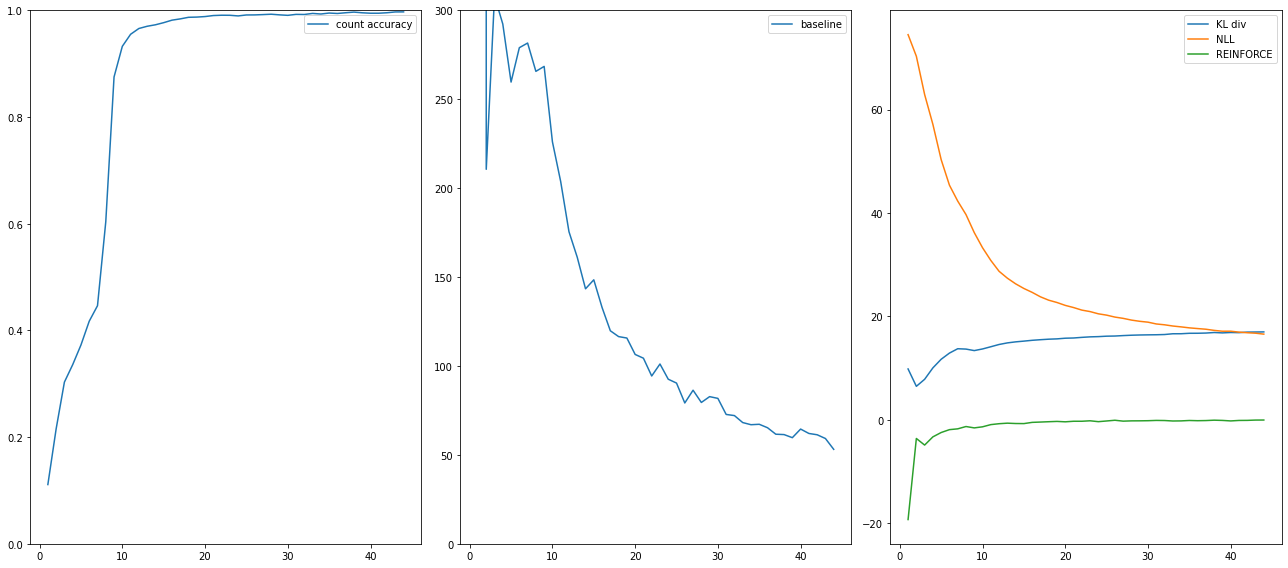

In [ ]:
air_model = AIR()
train_dataset = generate_dataset(num_images=10000, SEED=np.random.randint(1000))
trained_air = train(air_model, train_dataset)

In [ ]:
def plot_results(dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_samples = 7

    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)
    colors_rect = ['red', 'green', 'yellow']
    num_rows = len(EPOCHS_TO_SAVE_MODEL) + 1

    fig = plt.figure(figsize=(14, 8))
    for counter, i_sample in enumerate(i_samples):
        orig_img = dataset[i_sample][0]
        # data
        ax = plt.subplot(num_rows, n_samples, 1 + counter)
        plt.imshow(orig_img[0].numpy(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if counter == 0:
            ax.annotate('Data', xy=(-0.05, 0.5), xycoords='axes fraction',
                        fontsize=14, va='center', ha='right', rotation=90)
        for j, epoch in enumerate(EPOCHS_TO_SAVE_MODEL):
            trained_air = torch.load(f'./results/checkpoint_{epoch}.pth')
            trained_air.to(device)

            results = trained_air(orig_img.unsqueeze(0).to(device), True)

            attention_recs = results['attention_rects'].squeeze(0)
            x_tilde = torch.clamp(results['x_tilde'][0], 0 , 1)

            ax = plt.subplot(num_rows, n_samples, 1 + counter + n_samples*(j+1))
            plt.imshow(x_tilde[0].cpu().detach().numpy(), cmap='gray',
                       vmin=0, vmax=1)
            plt.axis('off')
            # show attention windows
            for step_counter, step in enumerate(range(N)):
                rect = attention_recs[step].detach().cpu().numpy()
                if rect.sum() > 0:  # valid rectangle
                    plt.plot(rect[0], rect[1]-0.5,
                             color=colors_rect[step_counter])
            if counter == 0:
                # compute accuracy
                data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
                avg_acc = 0
                for batch, label in data_loader:
                    label = label.unsqueeze(1).to(device)
                    r = trained_air(batch.to(device))
                    acc = (r['counts']==label).sum().item()/len(r['counts'])
                    avg_acc += acc / len(data_loader)
                # annotate plot
                ax.annotate(f'Epoch {epoch}\n Acc {avg_acc:.2f}',
                            xy=(-0.05, 0.5), va='center',
                            xycoords='axes fraction', fontsize=14,  ha='right',
                            rotation=90)
    return


test_dataset = generate_dataset(num_images=17, SEED=2)
plot_results(test_dataset)